In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Needed for advanced plotting
import matplotlib.patches as patches

# For plotting inline
%matplotlib inline
plt.ion()

In [2]:
# Import suftware (use development copy)
import sys
sys.path.append('../../suftware')

import suftware as sw

In [3]:
# Set default plotting parameters
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rc('text', usetex=True)
fontsize=9
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['hatch.color'] = 'black'

In [4]:
# Load raw information extracted from figure
raw_df = pd.read_excel('data/CMS2012.xlsx').fillna(0)

In [5]:
# Clean up dataframe
df = raw_df[['bins','data']].copy()
df['bg'] = raw_df['green']+raw_df['blue-green']
df['bg+H'] = df['bg'] + raw_df['red-blue']
df.head()

,bins,data,bg,bg+H
0,72,1.0,0.181,0.181
1,75,0.0,0.249,0.249
2,78,0.0,0.383,0.383
3,81,0.0,0.666,0.666
4,84,0.0,1.323,1.323


In [6]:
# How many of each type of event (bg or H) are expected?
expected_N_tot = df['bg+H'].sum()
expected_N_bg = df['bg'].sum()
expected_N_H = expected_N_tot-expected_N_bg
print('Expected N_tot: %.1f +/- %.1f'%(expected_N_tot,np.sqrt(expected_N_tot)))
print('Expected N_bg: %.1f +/- %.1f'%(expected_N_bg,np.sqrt(expected_N_bg)))
print('Expected N_H: %.1f +/- %.1f'%(expected_N_H,np.sqrt(expected_N_H)))
print('N_H / N_tot: %.1f%%'%(100*expected_N_H/expected_N_tot))

Expected N_tot: 71.3 +/- 8.4
Expected N_bg: 63.9 +/- 8.0
Expected N_H: 7.4 +/- 2.7
N_H / N_tot: 10.3%


In [7]:
# Generate data so SUFTware can histogram it again. Shouldn't have to do this.
data = []
for n, row in df.iterrows():
    data.extend([row['bins']]*int(row['data']))
grid = df['bins'].values

print('Dataset: %s'%repr(data))

Dataset: [72.0, 87.0, 87.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 93.0, 93.0, 93.0, 93.0, 93.0, 96.0, 96.0, 96.0, 96.0, 96.0, 99.0, 99.0, 99.0, 102.0, 114.0, 117.0, 120.0, 123.0, 123.0, 123.0, 126.0, 126.0, 126.0, 126.0, 129.0, 129.0, 132.0, 132.0, 138.0, 141.0, 144.0, 147.0, 147.0, 153.0, 156.0, 162.0, 165.0, 165.0, 165.0, 168.0, 174.0, 174.0, 177.0, 177.0, 180.0, 180.0, 180.0]


In [8]:
# Do density estimation
num_samples = 1000
density = sw.DensityEstimator(data=data,grid=grid,num_posterior_samples=num_samples, seed=0)

In [9]:
# Extract information to plot
bins = df['bins'].values
hist = df['data'].values
bg = df['bg'].values
bgH = df['bg+H'].values

N = df['data'].sum()
h = bins[1]-bins[0]

# Create xs to interpolate density on
xmin, xmax = density.bounding_box
xs = np.linspace(xmin,xmax,1000)

# Compute estimated densitya nd fluctuations
count_density = N*h*density.evaluate(xs)
count_fluctuations = N*h*density.evaluate_samples(xs)

In [10]:
xlim = density.bounding_box
ylim = [0,12]
def plot_higgs(ax, zorder=0):
    """
    Function to plot Higgs data similar to in CMS Collaboration, 2012, Fig. 3
    """
    
    # Plot Higgs prediction
    ax.step(bins,bgH,
           label='Higgs ($m_\mathrm{H}$=125 GeV)',
           where='mid',
           color='red',
           linewidth=1,
           zorder=zorder)

    # Plot background
    fill_blue=[.60,.81,1.00]
    ax.bar(bins,bg,
           label='background',
           width=h,
           color='lightskyblue',
           zorder=zorder)
    ax.step(bins,bg,color='k',linewidth=1,where='mid',zorder=zorder)
    
    # Plot data
    ax.plot(bins,hist, 
            markersize=3, 
            marker='o', 
            color='k',
            linewidth=0,
            label='data ($N$=%d)'%(N),
            zorder=zorder+1)

    # Style plot
    ax.set_xlim(xlim)
    ax.set_ylabel('events / 3 GeV')
    ax.set_ylim(ylim)
    yticks = np.arange(ylim[1]+1)
    yticklabels = [('%d'%y if y%2==0 else '') for y in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.legend()
    #ax.minorticks_on()
    
    # Label x axis
    ax.set_xlabel('$m_{4 \ell}$ (GeV)')

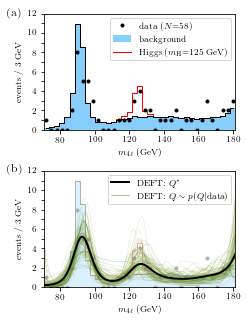

In [11]:
# Make Fig. 3 for manuscript
fig, axs = plt.subplots(2,1,figsize=[3.4,4.5])

### Panel (A)
ax = axs[0]
plot_higgs(ax, zorder=-10)

# Prepare legend
handles,labels = ax.get_legend_handles_labels()
indices=[1,2,0]
labels = [labels[i] for i in indices]
handles = [handles[i] for i in indices]
ax.legend(handles,labels, fontsize=9)

### Panel (B)
ax = axs[1]
plot_higgs(ax, zorder=-10)

# Create a Rectangle patch
rect = patches.Rectangle((xlim[0],ylim[0]),
                         xlim[1]-xlim[0],
                         ylim[1]-ylim[0],
                         facecolor='white',
                         edgecolor='white',
                         alpha=.7,
                         zorder=-1)

# Add the patch to the Axes
ax.add_patch(rect)

# Set number of posterior samples to show
num_samples_to_show=100

# Plot DEFT fluctuations
ax.plot(xs,100+count_fluctuations[:,0], 
        linewidth=.5, 
        alpha=1, 
        color='olivedrab',
        label='DEFT: $Q \sim p(Q|\mathrm{data})$',
        zorder=-1) # Dummy plot just for legend entry
ax.plot(xs,count_fluctuations[:,:num_samples_to_show], 
        linewidth=.5, 
        alpha=.2, 
        color='olivedrab',
        zorder=-1) 

# Plot DEFT best fit
ax.plot(xs,count_density, 
        label='DEFT: $Q^*$',
        linewidth=2,
        color='black',
        alpha=1,
        zorder=0)

# Prepare legend
handles,labels = ax.get_legend_handles_labels()
indices=[3,2]
labels = [labels[i] for i in indices]
handles = [handles[i] for i in indices]
ax.legend(handles,labels, fontsize=9)

# Label pannels
fig.text(x=.01, y=.98, s='(a)', fontsize=12, horizontalalignment='left', verticalalignment='top')
fig.text(x=.01, y=.50, s='(b)', fontsize=12, horizontalalignment='left', verticalalignment='top')

# Do tight layout
plt.tight_layout()

fig.savefig('figures/fig_3.pdf')

In [12]:
# Where is the maximum?
indices = (xs > 110) & (xs < 140)
tmp_xs = xs[indices]
tmp_density = density.evaluate(tmp_xs)
i = tmp_density.argmax()
print('Best estimate peaks at %.1f GeV'%tmp_xs[i])

tmp_samples = density.evaluate_samples(tmp_xs)
maxima = []
for j in range(num_samples):
    i = tmp_samples[:,j].argmax()
    maxima.append(tmp_xs[i])
maxima = np.array(maxima)
print('Samples peak at %.1f GeV +/- %0.1f GeV'%(maxima.mean(),maxima.std()))

Best estimate peaks at 126.7 GeV
Samples peak at 125.6 GeV +/- 6.4 GeV


In [13]:
# What fraction of points have exactly one interior maximum between 

def get_interior_maxima(ys, xs, xmin, xmax):
    """Counts number of interior maxima in a specified interval"""
    indices = (xs >= xmin) & (xs <= xmax)
    y = ys[indices]
    x = xs[indices]
    K = len(y)
    optima_locations = []
    for i in range(1,K-1):
        if y[i]>y[i-1] and y[i]>y[i+1]:
            optima_locations.append(x[i])
    return optima_locations

# Get number of posterior samples
num_samples = count_fluctuations.shape[1]
print('Num posterior samples: %d'%num_samples)

# Count interior maxima within a specified interval
xmin = 110
xmax = 140
print('In interval: [%.1f GeV, %.1f GeV]'%(xmin,xmax))
maxima_list = []
for n in range(num_samples):
    ys = count_fluctuations[:,n]
    interior_maxima = get_interior_maxima(ys,xs=xs,xmin=xmin,xmax=xmax)
    maxima_list.append(interior_maxima)
    
# Describe the number of interior maxima
num_no_maxima = sum([len(v)==0 for v in maxima_list])
print('Pct samples with no interior maxima: %.1f%%'%(100*num_no_maxima/num_samples))

num_single_maxima = sum([len(v)==1 for v in maxima_list])
print('Pct samples with one interior maximum: %.1f%%'%(100*num_single_maxima/num_samples))

num_multiple_maxima = sum([len(v)>=2 for v in maxima_list])
print('Pct samples with multipel interior maxima: = %.1f%%'%(100*num_multiple_maxima/num_samples))

# Compute the mean and std energy of lone maxima
lone_maxima = np.array([v for v in maxima_list if len(v)==1]).ravel()
print('Lone maxima: %.1f GeV +/- %0.1f GeV'%(lone_maxima.mean(), lone_maxima.std()))

Num posterior samples: 1000
In interval: [110.0 GeV, 140.0 GeV]
Pct samples with no interior maxima: 6.9%
Pct samples with one interior maximum: 81.2%
Pct samples with multipel interior maxima: = 11.9%
Lone maxima: 127.1 GeV +/- 3.7 GeV
